## Google Colab specific initialization cell
#For those users running this on google colab, this cell can be
#turned into a code cell and run. It will have colab install needed packages and,
#most importantly, it will clone the 'dataFiles' folder of this repository
#so that you can access it here.
#Use ctrl+m+y to convert to code cell in google colab

!git clone https://github.com/wesleymsmith/lipidMapVisualization.git
!ln -s lipidMapVisualization/dataFiles ./dataFiles

In [10]:
import numpy as np
import scipy as sp
from scipy import ndimage
import matplotlib
from matplotlib import pyplot as plt
import collections
import sys
import gc
import os
import sklearn as skl
from sklearn import decomposition
from sklearn import metrics
from sklearn import discriminant_analysis
from sklearn import cluster
import tqdm
import ipywidgets
import copy

from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets

# Load data

As always, our data is saved in chunks due to size limits.
Here, we need to load both the clustering data as well as the center of mass data

In [2]:
def saveArrayChunks(pathBase,arr,nChunks,axis=0,
                    pbar=None):
    """
        pathBase: the prefix of the file path to save each chunk to.
                    files will be named pathBase.chunk_#.npy, where # is
                    a zero padded integer (to make loading, sorting, etc easier)
        arr: the array to be saved
        axis: the axis along which to split the array ()
    """
    arrayChunks=np.array_split(arr,nChunks,axis=axis)
    ndigits=int(np.ceil(np.log10(nChunks)))
    digitStr='%'+'0%g'%ndigits+'g'
    if not pbar is None:
        pbar.n=len(arrayChunks)
        pbar.refresh()
        pbar.clear()
    for iChunk,arrayChunk in enumerate(arrayChunks):
        outPath='.'.join([pathBase,'chunk_%s'%(digitStr%iChunk),'npy'])
        np.save(outPath,arrayChunk)
        if not pbar is None:
            pbar.update()
            
def loadArrayChunks(pathBase,nChunks,axis=0,
                    pbar=None):
    arrayChunks=[]
    ndigits=int(np.ceil(np.log10(nChunks)))
    digitStr='%'+'0%g'%ndigits+'g'
    if not pbar is None:
        pbar.n=len(arrayChunks)
        pbar.refresh()
    for iChunk in np.arange(nChunks):
        dataPath='.'.join([pathBase,'chunk_%s'%(digitStr%iChunk),'npy'])
        arrayChunks.append(np.load(dataPath))
        if not pbar is None:
            pbar.update()
    return np.concatenate(arrayChunks,axis=axis)

In [3]:
dataFileDir='dataFiles'
comDataDir='/'.join([dataFileDir,'headgroupCoords'])
leafletClusteringDir='/'.join([dataFileDir,'leafletClustering'])

comFileTypeName='headgroup_COM_coords'

systems=['POPC','POPS','PIP2']

nChunks=4

comDataDict={}
print 'Loading data sets ',
with tqdm.tqdm_notebook() as pbar:
    for system in systems:
        print system,
        pbar.set_description_str(system)
        comFileNameBase='.'.join([system,comFileTypeName])
        comFilePathBase='/'.join([comDataDir,comFileNameBase])
        comDataDict[system]=loadArrayChunks(comFilePathBase,nChunks=nChunks,axis=1,
                                            pbar=pbar)
        gc.collect()
    print ''
print 'done loading data'
print '--- --- --- ---'

for setKey in comDataDict:
    print setKey,
    print comDataDict[setKey].shape

Loading data sets 

 POPC POPS PIP2 

done loading data
--- --- --- ---
POPC (1176, 2001, 3)
POPS (1282, 1592, 3)
PIP2 (1290, 1592, 3)


In [4]:
clusterDataDir='dataFiles/leafletClustering/'
clusterFileTypeName='leaflet_clustering_array'

systems=['POPC','PIP2','POPS']

nChunks=3

clusterDataDict={}
print 'Loading clustering data sets ',
with tqdm.tqdm_notebook() as pbar:
    for system in systems:
        print system,
        pbar.set_description_str(system)
        clusterFileNameBase='.'.join([system,clusterFileTypeName])
        clusterFilePathBase='/'.join([clusterDataDir,clusterFileNameBase])
        clusterDataDict[system]=loadArrayChunks(clusterFilePathBase,nChunks=nChunks,axis=0,
                                            pbar=pbar)
        gc.collect()
    print ''
print 'done loading data'
print '--- --- --- ---'

for setKey in clusterDataDict:
    print setKey,
    print clusterDataDict[setKey].shape

Loading clustering data sets 

 POPC PIP2 POPS 

done loading data
--- --- --- ---
POPC (2001, 1176)
POPS (1592, 1282)
PIP2 (1592, 1290)


# Membrane Height Calculation

Here we seek to calculate lipid heights based upon the center of mass coordinates of our lipid headgroups.

Before we can do so, we must first define our XY coordinate grids

## XY grid calculation

These simulations have been centered such that the center of mass of the protein lies on the origin. While the size of the simulation grid does fluctuate slightly from one frame to another due to use of a simulation barostat (NPT ensemble) the change is relatively small. We will thus attempt to use the same XY grid setup for all density and height calculations. This will simplify many computational considerations. It also means that we only need to calculate the XY grid one time. If this is already done, then you don't need to run the next cell, just run the loading cell below.

In [5]:
#Compute an XY grid for each system and save it to disk.
#only needs to be run once unless new systems are being analyzed.
outDir=dataFileDir
gridSpacing=1.0 #1 Å grid
for system in comDataDict:
    print '--- %s ---'%system
    comData=comDataDict[system]
    gridBounds=np.array([
            [np.min(comData[:,0]),np.min(comData[:,1])],
            [np.max(comData[:,0]),np.max(comData[:,1])]])
    centerX=np.mean(gridBounds[:,0])
    centerY=np.mean(gridBounds[:,1])
    nX=int(np.ceil((gridBounds[1,0]-gridBounds[0,0])/gridSpacing))+1
    nY=int(np.ceil((gridBounds[1,1]-gridBounds[0,1])/gridSpacing))+1
    pointsX=np.linspace(centerX-(nX-1)*gridSpacing/2,
                        centerX+(nX-1)*gridSpacing/2,
                        nX)
    pointsY=np.linspace(centerY-(nY-1)*gridSpacing/2,
                        centerY+(nY-1)*gridSpacing/2,
                        nY)
    gridX,gridY=np.meshgrid(pointsX,pointsY)
    print '%s Grid shape: '%system,
    print gridX.shape
    print '%s Grid Bounds: '%system,
    print gridBounds
    print 'saving to disk...'
    outFileName='.'.join([system,'gridX.npy'])
    outFilePath='/'.join([outDir,outFileName])
    np.save(outFilePath,arr=gridX)
    outFileName='.'.join([system,'gridY.npy'])
    outFilePath='/'.join([outDir,outFileName])
    np.save(outFilePath,arr=gridY)

--- POPC ---
POPC Grid shape:  (230, 229)
POPC Grid Bounds:  [[ -7.08916131  -5.28010502]
 [220.81656324 222.76967284]]
saving to disk...
--- POPS ---
POPS Grid shape:  (232, 233)
POPS Grid Bounds:  [[ -7.18940158  -4.86527905]
 [224.4948777  225.75348258]]
saving to disk...
--- PIP2 ---
PIP2 Grid shape:  (235, 233)
PIP2 Grid Bounds:  [[ -2.96129944  -3.34464858]
 [229.03306636 229.90644927]]
saving to disk...


If the XY grid has already been generated, you may run this cell to load it from disk

In [6]:
gridXdict={}
gridYdict={}
gridBoundsDict={}
for system in comDataDict:
    print '--- %s ---'%system
    gridXfileName='.'.join([system,'gridX.npy'])
    gridXfilePath='/'.join([dataFileDir,gridXfileName])
    gridXdict[system]=np.load(gridXfilePath)
    gridYfileName='.'.join([system,'gridY.npy'])
    gridYfilePath='/'.join([dataFileDir,gridYfileName])
    gridYdict[system]=np.load(gridYfilePath)
    print '%s Grid shape: '%system,
    print gridXdict[system].shape
    gridBoundsDict[system]=[
        [np.min(gridXdict[system]),np.min(gridYdict[system])],
        [np.max(gridXdict[system]),np.max(gridYdict[system])]
    ]
    print '%s Grid Bounds: '%system,
    print gridBoundsDict[system]

--- POPC ---
POPC Grid shape:  (230, 229)
POPC Grid Bounds:  [[-7.136299035217178, -5.755216087030789], [220.86370096478282, 223.2447839129692]]
--- POPS ---
POPS Grid shape:  (232, 233)
POPS Grid Bounds:  [[-7.34726194302722, -5.0558982344096535], [224.6527380569728, 225.94410176559035]]
--- PIP2 ---
PIP2 Grid shape:  (235, 233)
PIP2 Grid Bounds:  [[-2.9641165389713535, -3.7190996543211696], [229.03588346102865, 230.28090034567884]]


## Grid height interpolation scheme

We now have COM data and leaflet occupancy for each lipid phosphate group. The next step is to interpolate / assign their heights (Z coordinates) onto a uniform 2D grid for each leaflet. Before starting this, there are a few more considerations.

As mentioned in the begining, we will be using the interpolation scheme based on equation S1 from <i>Biophysical Journal 116.5 (2019)</i>

$$h_{\varsigma,(x,y)}=\frac{
    \Sigma_i\frac{
        Z_{\varsigma,i}
    }{
        d^{2}_{i,(x,y)}
    }
    }{
    \Sigma_i\frac{
        1
    }{
        d^{2}_{i,(x,y)}
    }}$$
    
where $h$ is the value to be assigned to the gridpoint at $(x,y)$ on the interpolation grid, $\varsigma$ is a particular atom type, $Z_{\varsigma,i}$ is the height of the $i$th atom of type $\varsigma$ and $d^{2}_{i,(x,y)}$ is the distance from the $i$th atom of type $\sigma$ to the point $(x,y)$ (as measured from the projection of that atom onto the x,y plane)

the function below accomplishes this interpolation scheme.
Here, 'coordData' is the coordinates of all atoms of a given type in a single frame, gridX and gridY are matrices detailing the X and Y coordinates of each gridpoint (i.e. as obtained from calling np.meshgrid over a set of x and y points). For now, only regular rectangular grids are supported, although this function could be modified to support irregular meshes or grids in a relatively straightforward manner.

In [8]:
def gridHeight2D(coordData,gridX,gridY):
    '''
        comData: center of mass data for leaflet (nPoints x 3 array)
        nx,ny:   number of gridpoints along x / y
        bounds:  ((min_x,min_y),(max_x,max_y))
    '''
    nzInds=np.nonzero(1.+0.*gridX)
    gridIndArr=np.array([nzInds[0],nzInds[1]]).T
    gridCoordArr=np.array([
        [gridX[ii[0],ii[1]],gridY[ii[0],ii[1]]] \
        for ii in gridIndArr])
    gridVals=np.apply_along_axis(
        lambda x: np.sum(
            coordData[:,2]/np.sqrt(
                ((coordData[:,0]-x[0])**2)+((coordData[:,1]-x[1])**2)))/\
            np.sum(1/np.sqrt(
                ((coordData[:,0]-x[0])**2)+((coordData[:,1]-x[1])**2))),
        arr=gridCoordArr,
        axis=1)
    gridMat=np.zeros(gridX.shape)
    gridMat[nzInds]=gridVals
    return gridMat

Since this scheme has been hand coded here, it is a good idea run a test case first
and make sure it is providing reasonable results before applying it over our coordinate data.

Below is a simple test case applying this method to generate a 100$\times$100 grid for a 1000 points sampled randomly from a distribution consisting of the sum of two elliptical gaussian distributions on the interval [0,1]$\times$[0,1] in $\mathbb{R}^2$ to form a cross like shape, followed by a third in small gaussian in the lower left hand side.

Also shown is the subsequent application of a gaussian smoothing filter ($\sigma=1$) as is common to reduce noise when computing local curvatures

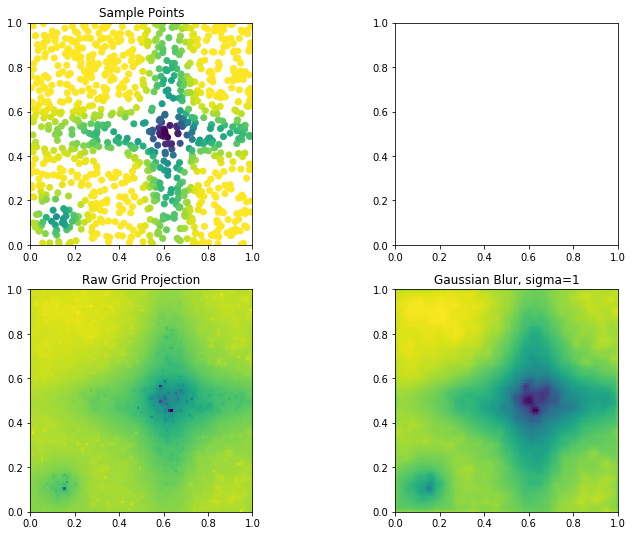

In [20]:
nX=100
nY=100
sampleArr=np.random.random([1000,3])
sampleArr[:,2]=3-np.exp(
    -(((.625-sampleArr[:,0])**2)/(1./144.)+\
      ((.5-sampleArr[:,1])**2)/(1./4.)))+\
    -np.exp(
    -(((.625-sampleArr[:,0])**2)/(1./4.)+\
      ((.5-sampleArr[:,1])**2)/(1./144.)))+\
    -np.exp(
    -(((.125-sampleArr[:,0])**2)/(1./121.)+\
      ((.125-sampleArr[:,1])**2)/(1./121.)))
sampleBounds=np.array([[0,1],[0,1]])
gridX,gridY=np.meshgrid(
    np.linspace(sampleBounds[0,0],sampleBounds[0,1],nX),
    np.linspace(sampleBounds[1,0],sampleBounds[1,1],nY))
gridMat=gridHeight2D(sampleArr,gridX,gridY)

fig,axs=plt.subplots(2,2)
fig.set_figheight(9)
fig.set_figwidth(12)
ax=axs.flat[0]
ax.scatter(sampleArr[:,0],
            sampleArr[:,1],
            c=sampleArr[:,2])
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_title('Sample Points')
axs.flat[1].set_aspect('equal')
ax=axs.flat[2]
ax.imshow((np.rot90(gridMat.T)),
          extent=(-0,1,0,1))
ax.set_title('Raw Grid Projection')
ax=axs.flat[3]
ax.imshow(sp.ndimage.filters.gaussian_filter(
            np.rot90(gridMat.T),sigma=1.,mode='wrap'),
          extent=(-0,1,0,1))
ax.set_title('Gaussian Blur, sigma=1')
plt.show()
#print sampleArr
#print gridMat

Now we are ready to compute grid interpolations of lealfet height / deformation.
This will take quite a while (~2 hr per trajectory)

In [ ]:
heightDataDir='/'.join([dataFileDir,'leafletHeight'])
upperHeightDict={}
lowerHeightDict={}
for system in comDataDict:
    gridX=gridXdict[system]
    gridY=gridYdict[system]
    comData=comDataDict[system]
    leafletIDs=clusterDataDict[system]

    leaflet0grid=np.zeros([comData.shape[1],gridX.shape[1],gridX.shape[0]])
    leaflet1grid=np.zeros([comData.shape[1],gridX.shape[1],gridX.shape[0]])

    with tqdm.tqdm_notebook(np.arange(comData.shape[1])) as pbar:
        pbar.set_description("%s"%system)
        for frame in pbar:
            coordData=comData[:,frame,:]
            leaflet0grid[frame]=np.rot90(gridHeight2D(coordData[leafletIDs[frame]==0],gridX,gridY))
            leaflet1grid[frame]=np.rot90(gridHeight2D(coordData[leafletIDs[frame]==1],gridX,gridY))
    upperHeightDict[system]=copy.deepcopy(leaflet0grid)
    lowerHeightDict[system]=copy.deepcopy(leaflet1grid)